
# Hate Speech Model using CNN
## Following notebook train and save weights of a CNN on a hate speech dataset
[You can download the dataset used from here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/ "jigsaw-dataset") <br>

[Glove word embeddings used can be downloaded from here](https://nlp.stanford.edu/projects/glove/)


In [1]:
#importing packages

from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,Dropout
from keras.models import Model
from keras.layers import SpatialDropout1D
from sklearn.metrics import roc_auc_score
from keras.models import model_from_json
from keras import regularizers
from keras import optimizers


2024-08-15 16:06:55.903136: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 16:06:55.907941: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 16:06:55.929025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 16:06:55.954222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 16:06:55.961646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 16:06:55.979125: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# some configuration 
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 22000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 20

In [4]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../../Data/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # word embedding file is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [6]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("../../Data/toxic-comment/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values # there are no na values in the data though
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values
print ("Shape of data:",(train.shape))
print ("First 5 rows:",(train.head()))


Loading in comments...
Shape of data: (159571, 8)
First 5 rows:                  id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [7]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sentences length:", s[len(s) // 2])


max sequence length: 1400
min sequence length: 0
median sentences length: 35


In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(word2idx))


Found 210337 unique tokens.


In [9]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

print('Completed...')

Filling pre-trained embeddings...
Completed...


In [ ]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


c:\Users\visha\anaconda3\envs\pyenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
print('Building model...')

# train a 1D convnet with global maxpooling
# spatial dropouts and L2 regularizers are used to prevent overfitting

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = SpatialDropout1D(0.4)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=optimizers.Adam(learning_rate=0.0008),  # updated parameter name
  metrics=['accuracy']
)
print('##############')
print('Model built...')
print(model.summary())


Building model...
##############
Model built...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 50)        │     1,100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 200, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 198, 128)       │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 66, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 66, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 64, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 19, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,235,174 (4.71 MB)

 Trainable params: 135,174 (528.02 KB)

 Non-trainable params: 1,100,000 (4.20 MB)

None


In [ ]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Training model...


Epoch 1/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 165s 120ms/step - accuracy: 0.7581 - loss: 0.1342 - val_accuracy: 0.9941 - val_loss: 0.0920
Epoch 2/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 128s 128ms/step - accuracy: 0.9817 - loss: 0.0896 - val_accuracy: 0.9941 - val_loss: 0.0901
Epoch 3/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 167s 167ms/step - accuracy: 0.9927 - loss: 0.0868 - val_accuracy: 0.9941 - val_loss: 0.0772
Epoch 4/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 196s 196ms/step - accuracy: 0.9938 - loss: 0.0841 - val_accuracy: 0.9941 - val_loss: 0.0752
Epoch 5/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 209s 209ms/step - accuracy: 0.9930 - loss: 0.0835 - val_accuracy: 0.9941 - val_loss: 0.0767
Epoch 6/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 166s 165ms/step - accuracy: 0.9941 - loss: 0.0810 - val_accuracy: 0.9941 - val_loss: 0.0798
Epoch 7/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 125s 125ms/step - accuracy: 0.9942 - loss: 0.0808 - val_accuracy: 0.9941 - val_loss: 0.0765
Epoch 8/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 113s 113ms/step - accuracy: 0.9940 -

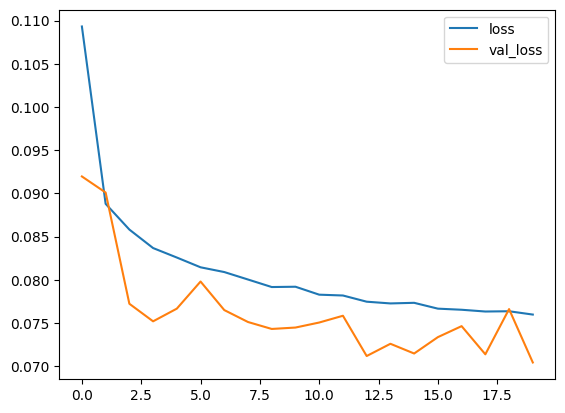

In [ ]:
# plot some data
%matplotlib inline

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

{'accuracy': [0.8761828541755676, 0.985836923122406, 0.9933884739875793, 0.9936391711235046, 0.9933415055274963, 0.993983805179596, 0.994101345539093, 0.9933884739875793, 0.9937096834182739, 0.9940073490142822, 0.9938036799430847, 0.993921160697937, 0.9936156272888184, 0.9929576516151428, 0.9926521182060242, 0.9933022856712341, 0.9937252998352051, 0.9935921430587769, 0.9928949475288391, 0.993090808391571], 'loss': [0.10931205749511719, 0.08879974484443665, 0.08582224696874619, 0.0836835727095604, 0.0825863853096962, 0.08145664632320404, 0.08090705424547195, 0.08004286885261536, 0.0791734829545021, 0.07920899242162704, 0.07829005271196365, 0.07819507271051407, 0.07747785747051239, 0.0772780254483223, 0.07734835147857666, 0.07667377591133118, 0.07654616981744766, 0.07634185999631882, 0.07637292146682739, 0.07598891854286194], 'val_accuracy': [0.9941093325614929, 0.9941093325614929, 0.9941093325614929, 0.9941093325614929, 0.9941093325614929, 0.9941093325614929, 0.9941093325614929, 0.99410

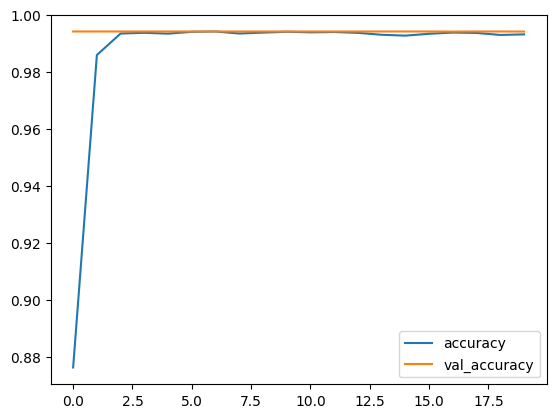

In [ ]:
# accuracies
print(r.history)

plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
    
print (aucs)
print(np.mean(aucs))

4987/4987 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step
[0.9483374300173326, 0.9810283511181332, 0.96517429318601, 0.9498844219613449, 0.9616358602622336, 0.9597807731441937]
0.9609735216148746


In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
tok= Tokenizer()
# Save model architecture to JSON
model_json = model.to_json()
with open("../../output/cnn_hate_speech.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to H5
model.save_weights("../../output/cnn_hate_speech.weights.h5")

# Save tokenizer to a pickle file
with open('../../output/hate_lstm.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# model_json = model.to_json()
# with open("cnn_hate_speech.json", "w") as json_file:
# 	json_file.write(model_json)
    
# # serialize weights to HDF5
# model.save_weights("cnn_hate_speech.h5")

print("Saved model to disk")

Saved model to disk
